## Import Libraries 

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import bisect

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.metrics import r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from datetime import datetime
import mlflow

import logging
import pickle

## Loading data

In [2]:
store_data = pd.read_csv('../data/store.csv', na_values=['?', None, 'undefined'])
train_data = pd.read_csv('../data/train.csv', na_values=['?', None, 'undefined'])
test_data = pd.read_csv('../data/test.csv', na_values=['?', None, 'undefined'])
submission_data = pd.read_csv('../data/sample_submission.csv', na_values=['?', None, 'undefined'])

## Data visualization

In [3]:
# store data
store_data.head(5)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [4]:
# train data
train_data.head(5)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
#test data
test_data.head(5)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


In [6]:
# sample submission data
submission_data.head(5)

,Id,Sales
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [7]:
# how many missing values exist or better still what is the % of missing values in the dataset?
def percent_missing(df, data_type):

    # Calculate total number of cells in dataframe
    totalCells = np.product(df.shape)

    # Count number of missing values per column
    missingCount = df.isnull().sum()

    # Calculate total number of missing values
    totalMissing = missingCount.sum()

    # Calculate percentage of missing values
    print(f"The {data_type} dataset contains", round(((totalMissing/totalCells) * 100), 2), "%", "missing values.")

percent_missing(train_data, 'train')
percent_missing(test_data, 'test')

The train dataset contains 0.0 % missing values.
The test dataset contains 0.0 % missing values.


## Preprocessing

In [8]:
#find the date part of the DatetimeIndex object.
def holiday(x):
    if x in ['a','b','c']:
        return 1
    return 0
    
def day_month_year(df, col):
    try:
        df['Day'] = pd.DatetimeIndex(df[col]).day
        df['Month'] = pd.DatetimeIndex(df[col]).month
        df['Year'] = pd.DatetimeIndex(df[col]).year
    except KeyError:
        print("Unknown Column Index")
    
train_data['Holiday'] = train_data['StateHoliday'].apply(holiday)
test_data['Holiday'] = test_data['StateHoliday'].apply(holiday)
train_data['Holiday'] = train_data['Holiday'] | train_data['SchoolHoliday']
test_data['Holiday'] = test_data['Holiday'] | test_data['SchoolHoliday']
day_month_year(train_data, 'Date') 
day_month_year(test_data, 'Date')

In [9]:
# drop missing value
test_data = test_data.dropna()
treain_data = train_data.dropna()

In [10]:
def weekends(x):
    if x >= 6:
        return 1
    return 0

def time_of_month(x):
    if x <= 10:
        return 0
    if x <= 20:
        return 1
    return 2

def label_holidays(x):
    if x in [0,'0','a','b','c']:
        return [0,'0','a','b','c'].index(x)
    return 5

def days_from_holiday(dates, holidays):
    days_till, days_after = [], []
    for day in dates:
        ind = bisect.bisect(holidays, day)
        if ind == 0:
            days_till.append((holidays[ind] - day).days)
            days_after.append(14)
        elif ind == len(holidays):
            days_till.append(14)
            days_after.append((day - holidays[ind - 1]).days)
        else:
            days_till.append((day - holidays[ind - 1]).days)
            days_after.append((holidays[ind] - day).days)
    return days_till, days_after

# change data formate 
train_data['Weekend'] = train_data['DayOfWeek'].apply(weekends)
test_data['Weekend'] = test_data['DayOfWeek'].apply(weekends)
train_data['TimeOfMonth'] = train_data['Day'].apply(time_of_month)
test_data['TimeOfMonth'] = test_data['Day'].apply(time_of_month)
train_data['Holiday'] = train_data['StateHoliday'].apply(label_holidays)
test_data['Holiday'] = test_data['StateHoliday'].apply(label_holidays)
train_data['Date'] = pd.DatetimeIndex(train_data['Date'])
test_data['Date'] = pd.DatetimeIndex(test_data['Date'])

In [11]:
test_data.describe()

,Id,Store,DayOfWeek,Open,Promo,SchoolHoliday,Holiday,Day,Month,Year,Weekend,TimeOfMonth
count,41077.000000,41077.000000,41077.000000,41077.000000,41077.000000,41077.000000,41077.000000,41077.000000,41077.000000,41077.0,41077.000000,41077.000000
mean,20548.560216,555.881832,3.979331,0.854322,0.395842,0.443606,1.004382,13.521435,8.353994,2015.0,0.291696,0.812572
std,11860.106172,320.315550,2.015529,0.352787,0.489037,0.496816,0.066052,8.449282,0.478213,0.0,0.454549,0.781518
min,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,8.000000,2015.0,0.000000,0.000000
25%,10280.000000,279.000000,2.000000,1.000000,0.000000,0.000000,1.000000,6.000000,8.000000,2015.0,0.000000,0.000000
50%,20550.000000,553.000000,4.000000,1.000000,0.000000,0.000000,1.000000,13.000000,8.000000,2015.0,0.000000,1.000000
75%,30819.000000,833.000000,6.000000,1.000000,1.000000,1.000000,1.000000,20.000000,9.000000,2015.0,1.000000,1.000000
max,41088.000000,1115.000000,7.000000,1.000000,1.000000,1.000000,2.000000,31.000000,9.000000,2015.0,1.000000,2.000000


In [12]:
train_data.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Holiday,Day,Month,Year,Weekend,TimeOfMonth
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01,9.163083e-01,1.570279e+01,5.846762e+00,2.013832e+03,2.845630e-01,1.012447e+00
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01,4.520516e-01,8.787638e+00,3.326097e+00,7.773960e-01,4.512063e-01,8.189388e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,2.013000e+03,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,8.000000e+00,3.000000e+00,2.013000e+03,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.600000e+01,6.000000e+00,2.014000e+03,0.000000e+00,1.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.300000e+01,8.000000e+00,2.014000e+03,1.000000e+00,2.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,3.100000e+01,1.200000e+01,2.015000e+03,1.000000e+00,2.000000e+00


## Analysis 

In [13]:
# Correlation between Sales and number of customers
train_data[['Customers','Sales']].corr()

,Customers,Sales
Customers,1.000000,0.894711
Sales,0.894711,1.000000


In [14]:
# Correlation between promo and sales
train_data[['Promo','Sales']].corr()

,Promo,Sales
Promo,1.000000,0.452345
Sales,0.452345,1.000000


In [15]:
# Correlation between promo, Customers and sales
train_data[['Promo', 'Customers','Sales']].corr()

,Promo,Customers,Sales
Promo,1.000000,0.316169,0.452345
Customers,0.316169,1.000000,0.894711
Sales,0.452345,0.894711,1.000000


In [16]:
# stores opened in weekdays (open = 1)
week_data = train_data[['Store', 'DayOfWeek','Open', 'Sales','Customers']]
week_data = week_data[week_data['Open'] == 1]
storeW_data = week_data[['Store', 'DayOfWeek']].groupby('Store').nunique()
storeW_data = storeW_data[storeW_data['DayOfWeek'] == 7].reset_index()
storeW_data

,Store,DayOfWeek
0,85,7
1,122,7
2,209,7
3,259,7
4,262,7
5,274,7
6,299,7
7,310,7
8,335,7
9,353,7


In [17]:
promo_sale = train_data[['Promo','Sales']].groupby('Promo').mean().reset_index()
promo_sale


,Promo,Sales
0,0,4406.050805
1,1,7991.152046


In [18]:
promo_customers = train_data[['Promo','Customers']].groupby('Promo').mean().reset_index()
promo_customers

,Promo,Customers
0,0,517.823542
1,1,820.098815


In [19]:
week_data = week_data[week_data['Store'].isin(set(week_data['Store']))]
weekendstores = set(week_data['Store'])
def isallweekstore(x):
    return (1 if x in weekendstores else 0)

train_data['7DayStore'] = train_data['Store'].apply(isallweekstore)
test_data['7DayStore'] = test_data['Store'].apply(isallweekstore)

In [20]:
store_data['CompetitionDistance'] = \
store_data['CompetitionDistance'].fillna(store_data['CompetitionDistance'].max())
store_data.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            0
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [21]:
train_data = train_data.merge(store_data, on='Store', how='left')
test_data = test_data.merge(store_data, on='Store', how='left')
holidays = np.array(train_data[train_data["Holiday"] > 1]["Date"].unique())
holidays = np.sort(holidays)
train_data["TillHday"], train_data["AfterHday"] = days_from_holiday(train_data["Date"], holidays)
holidays = np.array(test_data[test_data["Holiday"] > 1]["Date"].unique())
holidays = np.sort(holidays)
test_data["TillHday"], test_data["AfterHday"] = days_from_holiday(test_data["Date"], holidays)

In [22]:
le = preprocessing.LabelEncoder()
train_data['StoreType'] = le.fit_transform(train_data['StoreType'])
train_data['Assortment'] = le.fit_transform(train_data['Assortment'])
test_data['StoreType'] = le.fit_transform(test_data['StoreType'])
test_data['Assortment'] = le.fit_transform(test_data['Assortment'])

In [23]:
test_data[['TillHday','AfterHday']].sample(5)

,TillHday,AfterHday
40408,14,14
23676,14,6
29120,1,14
19045,14,11
40060,13,14


In [24]:
x = train_data[['Store', 'DayOfWeek', 'Open', 'Promo', 'Holiday', 'SchoolHoliday', 'Day',
              'Month', 'Year', 'Weekend' ,'TimeOfMonth', '7DayStore','StoreType',
              'Assortment','CompetitionDistance', 'Promo2', 'TillHday', 'AfterHday']]

y_scaler = StandardScaler()
y = y_scaler.fit_transform(train_data[['Sales']].values)
train_features = x.columns
x = x.values

### 5 fold cross validation

In [25]:
kf = KFold(n_splits=5)

2021/08/02 13:19:50 WARNING mlflow.tracking.context.git_context: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: cannot import name 'TypeGuard' from 'typing_extensions' (/home/doit/anaconda3/lib/python3.8/site-packages/typing_extensions.py)


Linear Regression Pipeline with k=5
score: 0.572723014321084
mean squared error: 0.43042746069723514
------------------------------------------------------
score: 0.5398009547885508
mean squared error: 0.47443160341518215
------------------------------------------------------
score: 0.5746813693217367
mean squared error: 0.41876672986794505
------------------------------------------------------
score: 0.5246249812757711
mean squared error: 0.48714599723845037
------------------------------------------------------
score: 0.5446401125789557
mean squared error: 0.4289427624982098
------------------------------------------------------
r2 score: 0.5446401125789557
mean squared error: 0.4289427624982098


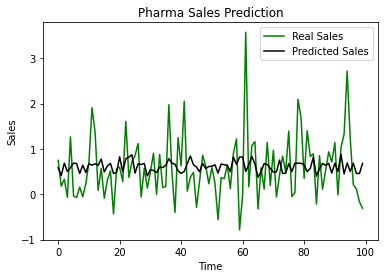

Random Forest Regressor with k=5
score: 0.8950861679842771
mean squared error: 0.10568740142835228
------------------------------------------------------
score: 0.883384127241746
mean squared error: 0.12022244737804348
------------------------------------------------------
score: 0.9047767066935717
mean squared error: 0.09375640818178517
------------------------------------------------------
score: 0.8715053578756766
mean squared error: 0.13167635679603057
------------------------------------------------------
score: 0.8964629232829608
mean squared error: 0.09753050484864338
------------------------------------------------------
r2 score: 0.8964629232829608
mean squared error: 0.09753050484864338


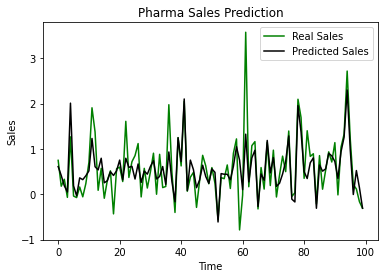

In [26]:
print("Linear Regression Pipeline with k=5")
for train_index, test_index in kf.split(x):
    with mlflow.start_run(run_name='linear_kfold', nested = True):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        reg_pipe = Pipeline([('scaler', StandardScaler()), ('model', LinearRegression())])
        reg_pipe.fit(X_train, y_train)
        score = reg_pipe.score(X_test, y_test)
        mse = mean_squared_error(y_test, reg_pipe.predict(X_test))
        print("score:", score)
        print("mean squared error:", mse)
        print("------------------------------------------------------")
        mlflow.log_param("lin_reg_score", score)
        mlflow.log_param("lin_reg_mse", mse)
        mlflow.sklearn.log_model(reg_pipe, "lin_regression_models")
        mlflow.end_run()
y_pred = reg_pipe.predict(X_test)
print('r2 score:', r2_score(y_test, y_pred))
print('mean squared error:', mean_squared_error(y_test, y_pred))
plt.plot(y_test[:100], color = 'green', label = 'Real Sales')
plt.plot(y_pred[:100], color = 'black', label = 'Predicted Sales')
plt.title('Pharma Sales Prediction')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

print("Random Forest Regressor with k=5")
for train_index, test_index in kf.split(x):
    with mlflow.start_run(run_name='random_forest_reg_kfold', nested = True):
        X_train, X_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        forest_pipe = Pipeline([('scaler', StandardScaler()), ('model', RandomForestRegressor(n_estimators = 8, max_depth = 20))])
        forest_pipe.fit(X_train, y_train)
        score = forest_pipe.score(X_test, y_test)
        mse = mean_squared_error(y_test, forest_pipe.predict(X_test))
        print("score:", score)
        print("mean squared error:", mse)
        print("------------------------------------------------------")
        mlflow.log_param("rand_forest_reg_score", score)
        mlflow.log_param("rand_forest_mse", mse)
        mlflow.sklearn.log_model(forest_pipe, "random_forest_regression_models")
        mlflow.end_run()
        y_pred = forest_pipe.predict(X_test)
print('r2 score:', r2_score(y_test, y_pred))
print('mean squared error:', mean_squared_error(y_test, y_pred))
plt.plot(y_test[:100], color = 'green', label = 'Real Sales')
plt.plot(y_pred[:100], color = 'black', label = 'Predicted Sales')
plt.title('Pharma Sales Prediction')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.show()

### Feature importance

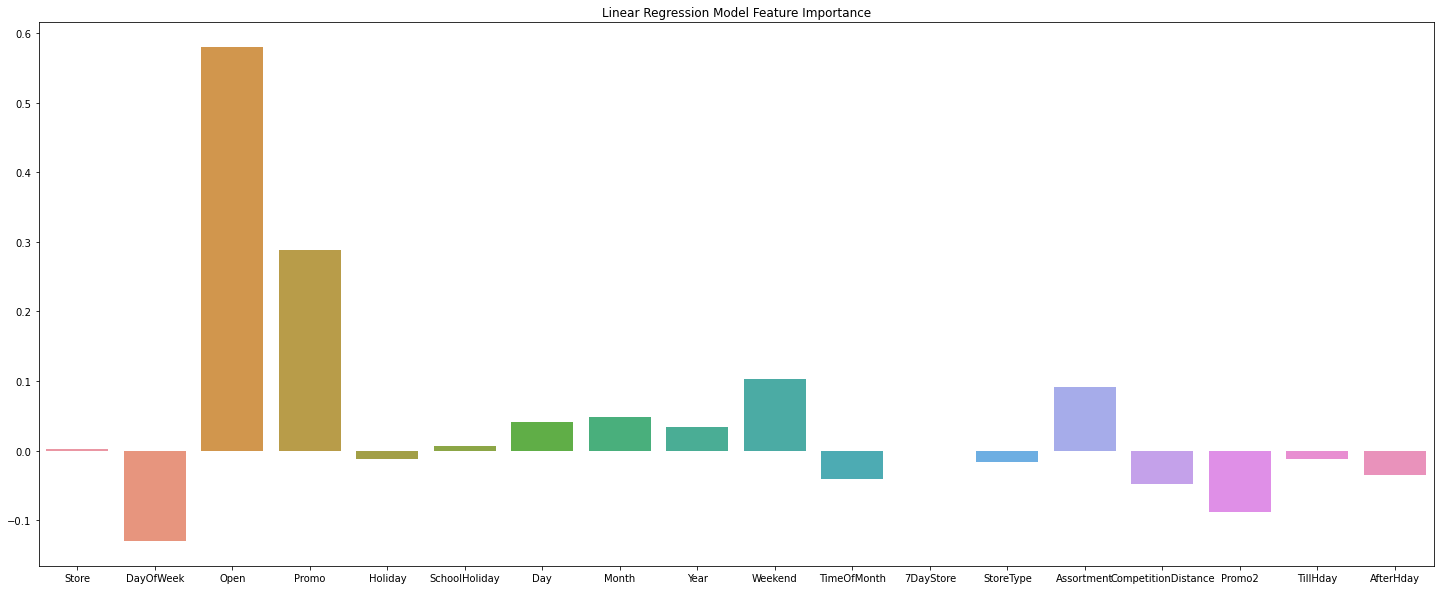

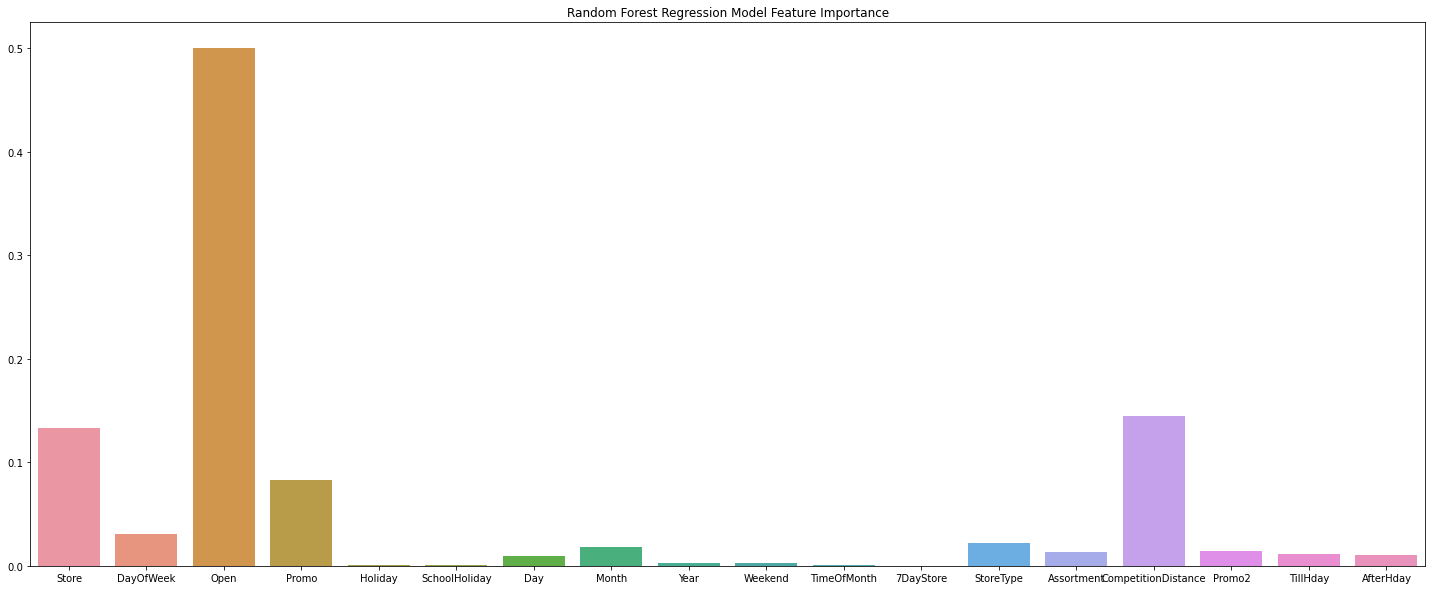

In [27]:
def featureImportance():
    #Linear Regression Model
    plt.figure(figsize=(25, 10))
    sns.barplot(x = train_features, y = reg_pipe[1].coef_[0])
    plt.title('Linear Regression Model Feature Importance')
    plt.show()

    #Random Forest Regression Model Feature Importance
    plt.figure(figsize=(25, 10))
    sns.barplot(x = train_features, y = forest_pipe[1].feature_importances_)
    plt.title('Random Forest Regression Model Feature Importance')
    plt.show()
featureImportance()

In [28]:
train_data = pd.read_csv('../data/train_final.csv', na_values=['?', None, 'undefined'])
test_data = pd.read_csv('../data/test_final.csv', na_values=['?', None, 'undefined'])

In [29]:
sales = train_data['Sales'].values
split = len(sales) // 2
X1, X2 = sales[0:split], sales[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=5899.006003, mean2=5648.632188
variance1=15322001.356660, variance2=14290490.101029


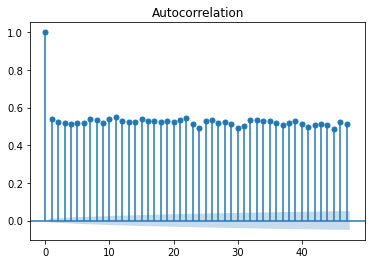

In [30]:
plot_acf(sales[:40000])
plt.show()

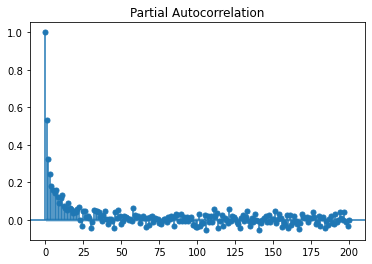

In [31]:
plot_pacf(sales[:30000], lags=200)
plt.show()

## Scale Data

In [32]:
def scale():
    X = train_data[train_data['Store'] == 16].values[:10000]
    #data['date'] = pd.to_numeric(pd.to_datetime(data['date']))
    sc_x = StandardScaler()
    X = sc_x.fit_transform(X)
    y = np.array(X[:,[-1]][7:])
    print(X.shape, y.shape)
    return X, y
    
def window(array, size):
    l = []
    for i in range(len(array)-size):
        l.append(array[i:i+size])
    return np.array(l)
X, y = scale()
w = window(X, 7)
print(w.shape)

(942, 19) (935, 1)
(935, 7, 19)


## Train Test Split

## Train and Test

Train the model
Epoch 1/10
148/148 [==============================] - 2s 2ms/step - loss: 1.0081
Epoch 2/10
148/148 [==============================] - 0s 2ms/step - loss: 0.9290
Epoch 3/10
148/148 [==============================] - 0s 2ms/step - loss: 0.5592
Epoch 4/10
148/148 [==============================] - 0s 2ms/step - loss: 0.3012
Epoch 5/10
148/148 [==============================] - 0s 2ms/step - loss: 0.2608
Epoch 6/10
148/148 [==============================] - 0s 3ms/step - loss: 0.2454
Epoch 7/10
148/148 [==============================] - 0s 2ms/step - loss: 0.2518
Epoch 8/10
148/148 [==============================] - 0s 2ms/step - loss: 0.2358
Epoch 9/10
148/148 [==============================] - 0s 2ms/step - loss: 0.2361
Epoch 10/10
148/148 [==============================] - 0s 2ms/step - loss: 0.2267
Test the model
r2 score: 0.8936693144390107
mean squared error: 0.06577264114921087


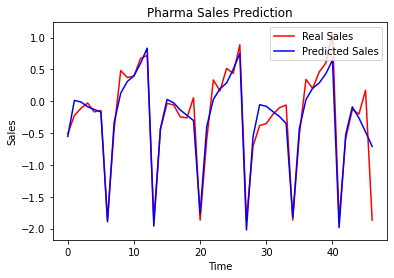

In [37]:
#train and test split
X_train, X_test, y_train, y_test = w[:int(len(w)*95/100)], \
w[int(len(w)*95/100):], y[:int(len(w)*95/100)], y[int(len(w)*95/100):]

#train the model
def train():
    regressor = Sequential()
    regressor.add(LSTM(20, activation = 'sigmoid', return_sequences=True, input_shape = (7, 19)))
    regressor.add(LSTM(10))
    regressor.add(Dense(1))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
    regressor.fit(X_train, y_train, batch_size = 6, epochs = 10)
    return regressor

#test the model    
def test(regressor):
    y_pred = regressor.predict(X_test)
    print('r2 score:', r2_score(y_test, y_pred))
    print('mean squared error:', mean_squared_error(y_test, y_pred))
    plt.plot(y_test, color = 'red', label = 'Real Sales')
    plt.plot(y_pred, color = 'blue', label = 'Predicted Sales')
    plt.title('Pharma Sales Prediction')
    plt.xlabel('Time')
    plt.ylabel('Sales')
    plt.legend()
    plt.show()

print('Train the model')
regressor = train()
print('Test the model')
test(regressor)